In [1]:
import requests as q
import json
import numpy as np

In [2]:
API_KEY = "D6427ILDPCC3RZCA"

def _api_call(symbol, candle="5min", output_size="compact"):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock}&interval={skip}&apikey={key}&outputsize={output_size}".format(
        stock=symbol, skip=candle, key=API_KEY, output_size=output_size
    )
    print("API::%s" % url)
    s = q.get(url)
    return s.json()

In [3]:
# test
d = _api_call('AMZN', candle="1min", output_size="full")
print(d['Meta Data'])

API::https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AMZN&interval=1min&apikey=D6427ILDPCC3RZCA&outputsize=full
{'1. Information': 'Intraday (1min) prices and volumes', '2. Symbol': 'AMZN', '3. Last Refreshed': '2018-02-05 16:00:00', '4. Interval': '1min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}


In [4]:
# get time series
ts = d['Time Series (1min)']
len(ts)

3910

In [5]:
def prep_data(ts):
    ts = list(ts.items())
    data = []
    for _, v in ts:
        v = v.items()
        data.append({key[3:]: float(val) for key, val in v})
    return data
            
data = prep_data(ts)
data[0]

{'close': 1390.0,
 'high': 1399.0,
 'low': 1388.81,
 'open': 1398.47,
 'volume': 38048.0}

In [6]:
def calc_pivots(p):
    pp = (p['high'] + p['low'] + p['close']) / 3
    r1 = pp * 2 - p['low']
    s1 = pp * 2 - p['high']
    r2 = pp + (p['high'] - p['low'])
    s2 = pp - (p['high'] - p['low'])
    r3 = p['high'] + 2 * (pp - p['low'])
    s3 = p['low'] - 2 * (p['high'] - pp)
    return s3, s2, s1, pp, r1, r2, r3

calc_pivots(data[1])

(1382.7733333333333,
 1388.0366666666666,
 1392.0433333333333,
 1397.3066666666666,
 1401.3133333333333,
 1406.5766666666666,
 1410.5833333333333)

In [7]:
import matplotlib.pyplot as plt

In [8]:
X = list(range(1, len(data)))
pivots = []
Y = []
for ix in range(1, len(data)):
    pivots.append(calc_pivots(data[ix-1]))
    Y.append(data[ix]['close'])
s3, s2, s1, pp, r1, r2, r3 = list(np.array(pivots).T)
len(Y)

3909

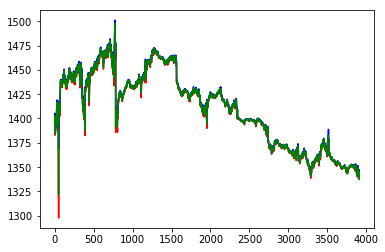

In [9]:
plt.plot(X, s1, 'r', X, r1, 'b', X, Y, 'g')
plt.show()

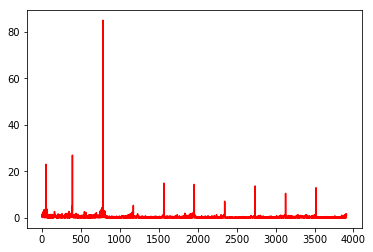

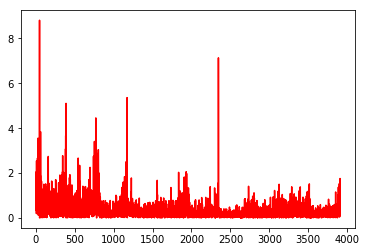

In [10]:
err = [min(abs(y - r1[i]), abs(y - s1[i])) for i, y in enumerate(Y)]

plt.plot(X, err, 'r')
plt.show()

low_err = [e if e < 10 else 0 for e in err]
plt.plot(X, low_err, 'r')
plt.show()

In [11]:
# LETS MAKE A FUCKING LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense, LeakyReLU

/home/lambda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
model = Sequential()
# our input will be the pivot points from the previous candle (7), and formatted to include a timestep
model.add(LSTM(1, input_shape=(1, 7), return_sequences=False))
model.add(LeakyReLU(alpha=0.01))
# model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam')

In [13]:
X = np.asarray(pivots)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
print(scaler.data_max_)
X_train = scaler.transform(X)
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print(X_train.shape)
print(X_train[0])

[1488.60666667 1490.59333333 1494.02666667 1496.01333333 1500.95333333
 1510.59666667 1525.07333333]
(3909, 7)
(3909, 1, 7)
[[0.56932473 0.50065392 0.45039335 0.34189564 0.35143989 0.36655978
  0.35536451]]


In [14]:
Y = np.asarray(Y)
print(Y[0])
print(Y.shape)
Y_r = Y - r1
Y_s = Y - s1
print(Y_r.shape)
print(Y_s.shape)
Y_train = np.asarray((Y_r, Y_s)).T
Y_train.shape

1396.05
(3909,)
(3909,)
(3909,)


(3909, 2)

In [17]:
model.fit(X_train, Y_train, epochs=400, batch_size=64, shuffle=True, validation_split=0.2)

Train on 3127 samples, validate on 782 samples
Epoch 1/400
3127/3127 [==============================] - 0s 47us/step - loss: 8.3035 - val_loss: 1.5831
Epoch 2/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3077 - val_loss: 1.5821
Epoch 3/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.3083 - val_loss: 1.5833
Epoch 4/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.3086 - val_loss: 1.5826
Epoch 5/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.3068 - val_loss: 1.5836
Epoch 6/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.3087 - val_loss: 1.5828
Epoch 7/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3056 - val_loss: 1.5843
Epoch 8/400
3127/3127 [==============================] - 0s 35us/step - loss: 8.3042 - val_loss: 1.5851
Epoch 9/400
3127/3127 [==============================] - 0s 36us/step - loss: 8.3041 - val_loss: 1.5840
Epoch 10/400
3127

3127/3127 [==============================] - 0s 34us/step - loss: 8.3023 - val_loss: 1.5845
Epoch 79/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3002 - val_loss: 1.5830
Epoch 80/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3015 - val_loss: 1.5842
Epoch 81/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3012 - val_loss: 1.5831
Epoch 82/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2963 - val_loss: 1.5838
Epoch 83/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3044 - val_loss: 1.5834
Epoch 84/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3051 - val_loss: 1.5821
Epoch 85/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.3007 - val_loss: 1.5825
Epoch 86/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.3031 - val_loss: 1.5839
Epoch 87/400
3127/3127 [==============================] - 0s 33us/st

3127/3127 [==============================] - 0s 34us/step - loss: 8.2974 - val_loss: 1.5851
Epoch 156/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2968 - val_loss: 1.5849
Epoch 157/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2992 - val_loss: 1.5839
Epoch 158/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2963 - val_loss: 1.5828
Epoch 159/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2998 - val_loss: 1.5836
Epoch 160/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2966 - val_loss: 1.5828
Epoch 161/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2942 - val_loss: 1.5853
Epoch 162/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2998 - val_loss: 1.5844
Epoch 163/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2986 - val_loss: 1.5837
Epoch 164/400
3127/3127 [==============================] - 0

3127/3127 [==============================] - 0s 36us/step - loss: 8.2921 - val_loss: 1.5861
Epoch 233/400
3127/3127 [==============================] - 0s 40us/step - loss: 8.2943 - val_loss: 1.5850
Epoch 234/400
3127/3127 [==============================] - 0s 38us/step - loss: 8.2939 - val_loss: 1.5865
Epoch 235/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2957 - val_loss: 1.5862
Epoch 236/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2925 - val_loss: 1.5872
Epoch 237/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2939 - val_loss: 1.5846
Epoch 238/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2918 - val_loss: 1.5848
Epoch 239/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2974 - val_loss: 1.5854
Epoch 240/400
3127/3127 [==============================] - 0s 35us/step - loss: 8.2949 - val_loss: 1.5858
Epoch 241/400
3127/3127 [==============================] - 0

3127/3127 [==============================] - 0s 34us/step - loss: 8.2947 - val_loss: 1.5877
Epoch 310/400
3127/3127 [==============================] - 0s 37us/step - loss: 8.2934 - val_loss: 1.5879
Epoch 311/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2947 - val_loss: 1.5871
Epoch 312/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2931 - val_loss: 1.5879
Epoch 313/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2914 - val_loss: 1.5897
Epoch 314/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2948 - val_loss: 1.5889
Epoch 315/400
3127/3127 [==============================] - 0s 34us/step - loss: 8.2919 - val_loss: 1.5905
Epoch 316/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2943 - val_loss: 1.5875
Epoch 317/400
3127/3127 [==============================] - 0s 33us/step - loss: 8.2940 - val_loss: 1.5881
Epoch 318/400
3127/3127 [==============================] - 0

KeyboardInterrupt: 

In [18]:
Yhat = model.predict(X_train)
print(Yhat.shape)

(3909, 2)


In [19]:
buy = True
capital = 1000
usd = capital
stock = 0
profit = []
threshold = 3
for i, x in enumerate(Y):
    buy_dist, sell_dist = Yhat[i]
    if abs(buy_dist) < threshold and buy:
        stock = usd / x
        usd = 0
        buy = False
    elif abs(sell_dist) < threshold and not buy:
        n_usd = stock * x
        if len(profit) > 0 and n_usd - capital < profit[-1]:
            continue
        usd = n_usd
        stock = 0
        buy = True
        profit.append(usd - capital)
        print("Profit: %f" % profit[-1])

Profit: 4.652412
Profit: 5.694292
Profit: 7.211534
Profit: 8.243018
Profit: 8.484082
Profit: 9.236345
Profit: 12.810128
Profit: 12.843750
Profit: 12.872384
Profit: 13.848197
Profit: 21.345348
Profit: 22.209487
Profit: 23.577464
Profit: 26.297471
Profit: 29.748967
Profit: 30.291923
Profit: 30.914850
Profit: 31.380695
Profit: 31.955702
Profit: 31.998556
Profit: 32.548152
Profit: 33.963973
Profit: 34.385449
Profit: 34.749446
Profit: 36.261260
Profit: 36.618742
Profit: 36.804478
Profit: 37.304249
Profit: 39.197551
Profit: 39.279822
Profit: 39.486831
Profit: 39.551043
Profit: 40.200086
Profit: 40.392937
Profit: 41.488677
Profit: 41.675298
Profit: 42.724980
Profit: 43.979160
Profit: 44.838851
Profit: 45.661762
Profit: 45.765486
Profit: 46.024674
Profit: 46.783524
Profit: 47.864015
Profit: 48.982568
Profit: 49.240613
Profit: 49.569544
Profit: 50.016527
Profit: 50.438326
Profit: 51.113930
Profit: 52.386119
Profit: 52.568556
Profit: 53.252188
Profit: 53.769148
Profit: 54.012442
Profit: 55.10738

In [20]:
print("Final profit: $%.02f" % profit[-1])

Final profit: $70.47


In [21]:
model.save('AMZN-1.hd5')